# Latent Dirichlet Allocation

In this final assignment, you will implement LDA and try it out on a corpus. Be sure to start work on this assignment early, because running your code will take some time. A full run of my implementation took about four hours. Consider running your code on smaller subcorpora during debugging.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data loading

Try your Gibbs sampler on the corpus of 2000 movie reviews from Pang & Lee (2004), available on Classroom. The first line of the file specifies the number of documents. Then each subsequent line is one document, with the tokens separated by whitespace. I generated the file on Classroom from the original movie reviews by tokenizing them and then removing punctuation and stopwords, so you get nicer topics.

In [3]:
# ! pip install pyLDAvis
# ! pip install wget

In [4]:
FORCE_RETRAIN_MODEL = True
PATH_TO_TRAINED_MODEL = '50_iters_model.json'

NUM_OF_TOPICS = 20
NUM_OF_ITERATIONS = 300
# -1 is default for saving only after full train
SAVE_EVERY_N_ITERATIONS = 50

SOURCE_DATA_FILENAME = 'before_docs.txt'

In [5]:
! ls

25_02_2022_19_16_37   baranov_scraper.py    main.py
25_02_2022_19_42_39   before_docs.txt       page_links.txt
LDA.ipynb             belapan_scraper.py    preprocessed_docs.txt
README.md             full_model.json       sb_articles.db
TODOs.txt             helper.py             sb_document.py
after_docs.txt        lda_solution.py       sb_scraper.py
after_model.json      links_to_reload.txt


In [6]:
import pyLDAvis

/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


In [7]:
from lda_solution import DataHelper

data_helper = DataHelper(SOURCE_DATA_FILENAME, NUM_OF_TOPICS)

print(data_helper.NUM_OF_DOCS, data_helper.VOCAB_SIZE, data_helper.CORPUS_SIZE)

TypeError: 'NoneType' object is not iterable

In [ ]:
# I wanted to check topic distribution prior to all training
# We can see that it is almost uniform
sb_vis_data = data_helper.get_lda_vis_data()
pyLDAvis.display(sb_vis_data)

/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/users/tsimafeip/pythonProje

## Gibbs sampler

Implement a Gibbs sampler which resamples a topic for each word in the corpus according to the probability distribution in formula [5] of [Griffiths & Steyvers (2004)](https://www.pnas.org/content/101/suppl_1/5228). Initialize the topic assignments by choosing a topic uniformly at random for each token in the corpus. You can also refer to [Darling tutorial](https://u.cs.biu.ac.il/~89-680/darling-lda.pdf) for details of implementation.

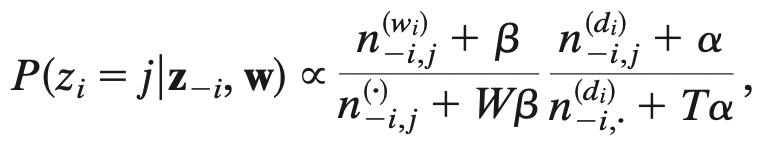

[63436, 63038, 63747, 63303, 63301, 63569, 63972, 64007, 63377, 63575, 63907, 63618, 63268, 63444, 63744, 63262, 63673, 63434, 63498, 63888]


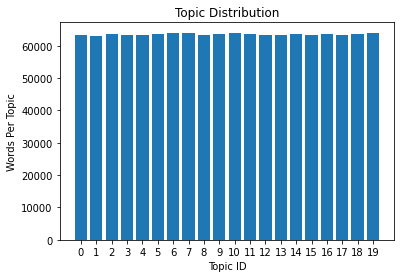

In [ ]:
from lda_solution import plot_topic_distribution

print(data_helper.topic_counter)
plot_topic_distribution(data_helper.topic_counter)

Algorithm
```
        run for NUM_OF_ITERATIONS (hyperparam)
            for each word_document pair in corpus
                get current topic
                decrease all respective counts:
                    - general count of this topic;
                    - count of this topic for specific word;
                    - count of this topic in document;
                run loop over topics count K
                    re-evaluate word_to_topic sampling probabilites
                choose new topic for the word based on weights obtained above
                increase all respective counts
```

Apply Gibbs sample to full corpus:

In [ ]:
from lda_solution import GibbsSampler

if FORCE_RETRAIN_MODEL:
    gibbs_sampler = GibbsSampler(data_helper)
    data_helper = gibbs_sampler.train(NUM_OF_ITERATIONS, iterations_to_save=SAVE_EVERY_N_ITERATIONS)
    path_to_trained_helper = data_helper.export_trained_helper()
else:
    data_helper = DataHelper.import_trained_helper(
        path_to_model_file=PATH_TO_TRAINED_MODEL,
        base_data_helper=data_helper,
    )
    data_helper.run_consistency_tests()

  0%|          | 0/300 [00:00<?, ?it/s]


KeyboardInterrupt: 

[121580, 164018, 285696, 238132, 457648, 262262, 338190, 205370, 283266, 321733, 66136, 340603, 62536, 284740, 361161, 110915, 229618, 69712, 192794, 377489]


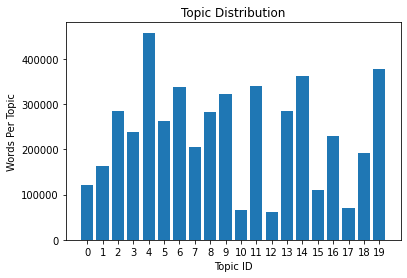

In [ ]:
# distribution after training
print(data_helper.topic_counter)
plot_topic_distribution(data_helper.topic_counter)

I have decided to use [pyLDAvis](!https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) and set $\lambda$ (relevance metric parameter) to 0.2 to check unique words for each topic. Also, PCA plot helps to understand whether we learned some different topics or not.

In [ ]:
# 50 iters, default parameters
full_corpus_data_helper = DataHelper.import_trained_helper(
    path_to_model_file='full_model.json',
    path_to_source_data='preprocessed_docs.txt',
)
full_corpus_data_helper.run_consistency_tests()

print(full_corpus_data_helper.NUM_OF_DOCS, full_corpus_data_helper.VOCAB_SIZE, full_corpus_data_helper.CORPUS_SIZE)
full_vis_data = full_corpus_data_helper.get_lda_vis_data()
pyLDAvis.display(full_vis_data)

19334 111787 4773600


In [ ]:
# 100 iters, default parameters
after_corpus_data_helper = DataHelper.import_trained_helper(
    path_to_model_file='after_model.json',
    path_to_source_data='after_docs.txt',
)
after_corpus_data_helper.run_consistency_tests()

print(after_corpus_data_helper.NUM_OF_DOCS, after_corpus_data_helper.VOCAB_SIZE, after_corpus_data_helper.CORPUS_SIZE)
after_vis_data = after_corpus_data_helper.get_lda_vis_data()
pyLDAvis.display(after_vis_data)

5308 37034 1271061


In [ ]:
# 100 iters, default parameters
after_corpus_data_helper = DataHelper.import_trained_helper(
    path_to_model_file='after_model.json',
    path_to_source_data='after_docs.txt',
)
after_corpus_data_helper.run_consistency_tests()

print(after_corpus_data_helper.NUM_OF_DOCS, after_corpus_data_helper.VOCAB_SIZE, after_corpus_data_helper.CORPUS_SIZE)
after_vis_data = after_corpus_data_helper.get_lda_vis_data()
pyLDAvis.display(after_vis_data)